In [39]:
import numpy as np
import pandas as pd
from Evaluator import ModelEvaluator
import torch
import random
from matplotlib import pylab as plt
from IPython.display import clear_output
import copy

In [40]:
data=pd.read_csv('datasets/malicious_data_generated.csv')
npdata=data.to_numpy()
malData=np.copy(npdata)
print(type(malData[1,:]))
print(malData[:1].shape)

<class 'numpy.ndarray'>
(1, 10)


In [41]:
data.describe()

,-32.0,-36.0,-85.0,72.0,-16.0,-44.0,-9.0,35.0,-60.0,85.0
count,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000
mean,-36.873747,-43.074148,-32.785571,-3.418838,-42.597194,4.995992,-30.392786,17.905812,-20.090180,59.875752
std,39.204926,42.480476,50.212121,57.132754,40.686332,56.766909,47.577099,49.094626,55.913282,24.014733
min,-95.000000,-98.000000,-100.000000,-100.000000,-95.000000,-102.000000,-98.000000,-98.000000,-99.000000,-66.000000
25%,-67.000000,-78.500000,-78.000000,-56.500000,-69.000000,-42.000000,-78.000000,2.000000,-61.000000,43.000000
50%,-41.000000,-54.000000,-49.000000,-12.000000,-54.000000,11.000000,-31.000000,28.000000,-38.000000,61.000000
75%,-15.000000,-12.000000,-7.000000,42.000000,-26.000000,52.500000,-4.000000,51.000000,25.000000,79.000000
max,71.000000,102.000000,98.000000,94.000000,92.000000,96.000000,94.000000,100.000000,101.000000,101.000000


## control

In [42]:
totalEpochs=1000
totalNumAdversarialData=500
saveValue=totalEpochs-totalNumAdversarialData
if saveValue<=0:
    saveValue=0
totalItemsConv=0

In [43]:
features=['A','B','C','D','F','G','H','I','j','k']
df=pd.DataFrame(columns=features)

In [44]:
class MalwareEnv():
    def __init__(self,totalEpochs):
        # Actions we can take, decrease, increse
        self.action_space = 20  
        # Set start 
        self.state = np.asarray(malData[random.randint(0,498),:])
        #model to evaluate the reward
        self.evaluator=ModelEvaluator()
        #units to move
        self.block=10
        #number of items saved
        self.savedItems=0
        #pointcritic
        self.pointCritic=totalEpochs-totalNumAdversarialData
        #loss
        self.hit=0
        
    def reset(self):
        self.state = np.asarray(malData[random.randint(0,498),:])
        
        
    def step(self, action):
        
        if(action<9):
            self.state[action]+=self.block
        elif(action>=9 and action<19):
            self.state[action-9]-=self.block
            
        
    def reward(self):
        reward=-1
        value=self.state.tolist()
        result=self.evaluator.test(value)
        result=np.array2string(result)
        
        if(result=="['benign']"):
            self.hit+=1
            reward=+10
            self.saveItem()
                 
        return reward    
    
    def saveItem(self):
        
        
        if self.hit>self.pointCritic:
            
            print("saveddddddddddddddddddddddddddddddddddd")
            
            formatier=self.state.reshape(1,-1)[0]
            df.loc[self.savedItems]=formatier
            self.savedItems+=1
            

    def render_np(self):
        return self.state
    

In [45]:


l1 = 10
l2 = 24
l3 = 72
l4 = 20
model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
#device=torch.device("cuda:0" if torch.cuda.is_available else "cpu")
model.cuda()
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
gamma = 0.9
epsilon = 1.0

In [46]:
epochs = copy.copy(totalEpochs)
losses = [] 
env = MalwareEnv(totalEpochs)


for i in range(epochs): 
    env.reset()
    state_ = env.render_np().reshape(1,10) + np.random.rand(1,10)/50.0 
    state1 = torch.from_numpy(state_).float() 
    status = 1 
    while(status == 1): 
        qval = model(state1.cuda()) 
        qval_ = qval.data.cpu().numpy()
        if (random.random() < epsilon):
            action_ = np.random.randint(0,20)
        else:
            action_ = np.argmax(qval_)
        
        env.step(action_) 
        state2_ = env.render_np().reshape(1,10) + np.random.rand(1,10)/50.0
        state2 = torch.from_numpy(state2_).float() 
        reward = env.reward()
        with torch.no_grad():
            newQ = model(state2.reshape(1,10).cuda())
        maxQ = torch.max(newQ) 
        if reward == -1: 
            Y = reward + (gamma * maxQ)
        else:
            Y = reward
        Y = torch.Tensor([Y]).detach()
        X = qval.squeeze()[action_] 
        loss = loss_fn(X.cuda(), Y.cuda()) 
        print(i, loss.item())
        clear_output(wait=True)
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        state1 = state2
        if reward != -1: 
            status = 0
    if epsilon > 0.1: 
        epsilon -= (1/epochs)

saveddddddddddddddddddddddddddddddddddd
999 0.02434556558728218


D:\programas\anaco\envs\latest tf 101021\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [47]:
losses
#clear_output(wait=True)

[46.321102142333984,
 17.9354248046875,
 4.440326690673828,
 8.698288917541504,
 261.3653564453125,
 10.902463912963867,
 88.45780181884766,
 227.70553588867188,
 2.2785141468048096,
 160.56333923339844,
 1.8747236728668213,
 5.718616485595703,
 25.064897537231445,
 88.42346954345703,
 21.323572158813477,
 29.890247344970703,
 93.78968048095703,
 100.23222351074219,
 3.5262205600738525,
 6.207352161407471,
 3.294753074645996,
 0.037592630833387375,
 34.64750289916992,
 2.132012367248535,
 70.81983184814453,
 67.47018432617188,
 42.61036682128906,
 18.797365188598633,
 19.4282283782959,
 0.007637085858732462,
 2.8924787044525146,
 24.795446395874023,
 2.001152276992798,
 36.74773025512695,
 9.36506175994873,
 24.92176055908203,
 0.004681287333369255,
 0.629378080368042,
 45.92747116088867,
 95.70912170410156,
 187.494384765625,
 117.33158111572266,
 60.62549591064453,
 96.82980346679688,
 26.06719398498535,
 99.77117156982422,
 135.17921447753906,
 98.73550415039062,
 31.854381561279297

Text(0, 0.5, 'Loss')

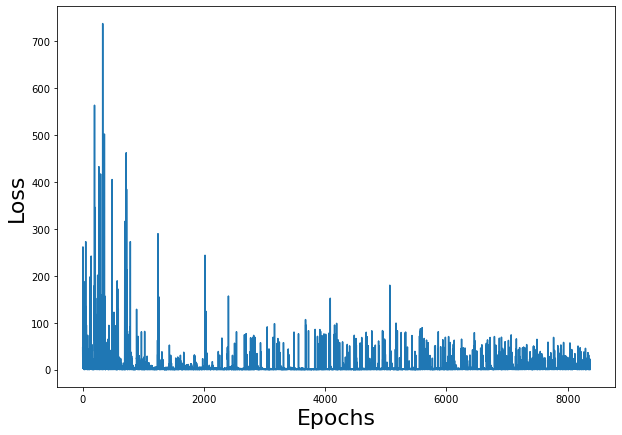

In [48]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [49]:
df

,A,B,C,D,F,G,H,I,j,k
0,-95.0,4.0,-107.0,70.0,-45.0,44.0,-38.0,33.0,-78.0,31.0
1,-32.0,-38.0,6.0,-75.0,-66.0,-26.0,-10.0,76.0,-52.0,32.0
2,-102.0,-69.0,-86.0,28.0,-63.0,110.0,-41.0,28.0,-51.0,15.0
3,-34.0,-4.0,-14.0,-97.0,-63.0,-26.0,11.0,48.0,-65.0,60.0
4,-66.0,-86.0,-17.0,40.0,7.0,90.0,-96.0,26.0,-49.0,96.0
...,...,...,...,...,...,...,...,...,...,...
495,-47.0,33.0,-54.0,39.0,-78.0,17.0,29.0,-106.0,47.0,44.0
496,-125.0,101.0,-41.0,15.0,-65.0,58.0,7.0,-34.0,56.0,25.0
497,-30.0,-57.0,7.0,-25.0,34.0,-66.0,7.0,2.0,-46.0,67.0
498,-19.0,-76.0,65.0,-79.0,-60.0,-81.0,-15.0,34.0,-32.0,84.0


In [50]:
df.to_csv('datasets/Adversarial_data.csv' ,header=False,index=False)

In [51]:
torch.save(model.state_dict(), 'DRLMalwareModificator.sav')